<a href="https://colab.research.google.com/github/nielsrolf/ddsp/blob/master/fmsynth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+git://github.com/nielsrolf/ddsp &> /dev/null

# Base waves

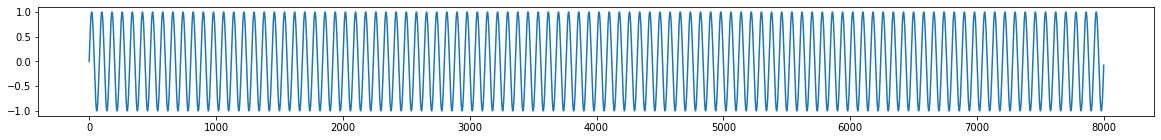

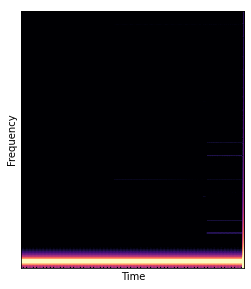

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


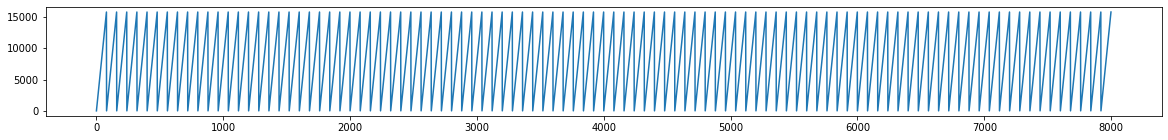

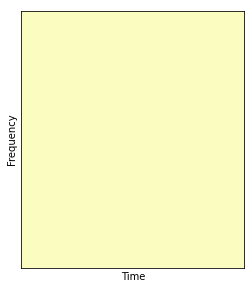

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


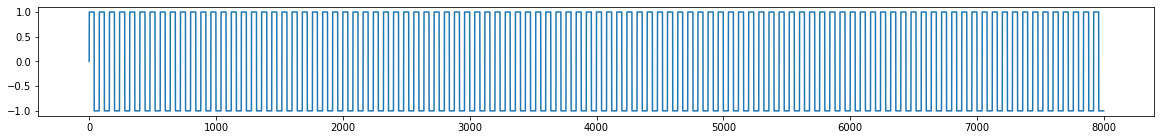

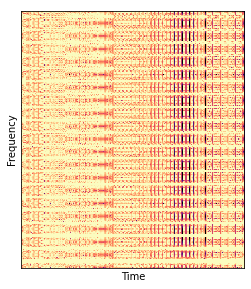

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [54]:
import tensorflow as tf
from ddsp.training.plotting import specplot
from IPython.display import display, Audio
import numpy as np
from matplotlib import pyplot as plt

time = tf.range(0., 64000, 1.)


def play(audio):
    plt.figure(figsize=(20, 2))
    plt.plot(audio[:8000])
    plt.show()
    display(Audio(data=audio, rate=16000))
    specplot(audio)
    plt.show()
    print("-"*200)


def sinus1hz(x, sample_rate=16000):
    return tf.sin(x * 2 * np.pi / sample_rate)


def saw1hz(x, sample_rate=16000):
    return tf.math.floormod(x, sample_rate)


def square1hz(x, ratio=1, sample_rate=16000):
    return tf.sign(sinus1hz(x, sample_rate=sample_rate))


play(sinus1hz(time*200))
play(saw1hz(time*200))
play(square1hz(time*200))

# Modulation

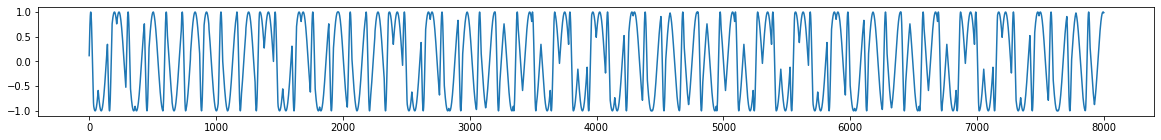

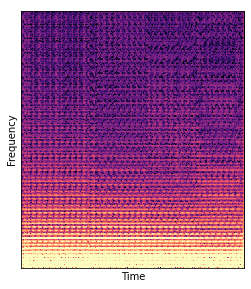

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [32]:
tfkl = tf.keras.layers




class Modulator(tfkl.Layer):
  def __init__(self, wave_func=sinus1hz, time_axis=0):
    super().__init__()
    self.wave_func = wave_func
    self.time_axis = time_axis

  def call(self, carrier_f, modulator_f, modulator_amp):
    """
    carrier: (batch, time, channels): frequency envelopes for a 
    modulator: (batch, time, channels)
    """
    modulated_phase = carrier_f + self.wave_func(tf.cumsum(modulator_f, axis=self.time_axis)) * modulator_amp
    return modulated_phase

class RelativeModulator(tfkl.Layer):
  def __init__(self, wave_func=sinus1hz, time_axis=0):
    super().__init__()
    self.wave_func = wave_func
    self.time_axis = time_axis

  def call(self, carrier_f, relative_modulator_f, modulator_amp):
    """
    carrier: (batch, time, channels): frequency envelopes for a 
    modulator: (batch, time, channels)
    """
    modulated_phase = carrier_f + self.wave_func(tf.cumsum(relative_modulator_f*carrier_f, axis=self.time_axis)) * modulator_amp
    return modulated_phase

op = RelativeModulator(wave_func=square1hz,time_axis=0)

f0 = time*0 + 100
mod_f0 = time*0 + 1.1
mod_amp = 100

mod_phase = op(f0, mod_f0, mod_amp)
mod_phase = op(mod_phase, mod_f0, mod_amp)
mod_signal = sinus1hz(tf.cumsum(mod_phase))



play(mod_signal)

# Synthesizer DAG


In [3]:
class Note():
    def __init__(self, start, dur, vel, hz=200):
        self.start = start
        self.dur = dur
        self.vel = vel
        self.hz = hz


class Loop():
    def __init__(self, duration, channels=[], sample_rate=16000):
        """
        Channel: {note_synth: Note_synth, notes=[Notes]}
        """
        self.duration = duration
        self.channels = channels
        self.sample_rate = sample_rate
    
    def synthesize(self, n_loops=4, base_sound_frames=64000):
        audio = np.zeros(int(self.sample_rate*self.duration)*n_loops + base_sound_frames)
        for c in self.channels:
            synth = c['note_synth']
            for note in c['notes']:
                new_note = synth(note)
                for i in range(n_loops):
                    start_frame = int(i * self.sample_rate * self.duration + self.sample_rate * note.start) 
                    audio[start_frame:start_frame+base_sound_frames] += new_note
        return audio
    
    def change_tempo(self, target_duration):
        scale = target_duration / self.duration
        self.duration = target_duration
        def transform(i):
            return Note(i.start*scale, i.dur*scale, i.vel, i.hz)
        for c in self.channels:
            c['notes'] = [transform(i) for i in c['notes']]
            e = c['note_synth'].envelope
            e.attack *= scale
            e.decay *= scale
            e.relieve *= scale



class ADSREnvelope():
    def __init__(self, attack=0.1, decay=0.2, sustain=0.7, relieve=0.1):
        self.attack = attack
        self.decay = attack + decay
        self.sustain = sustain
        self.relieve = relieve


def linspace(a, b, c):
    return tf.cast(tf.linspace(a, b, c), tf.float32)





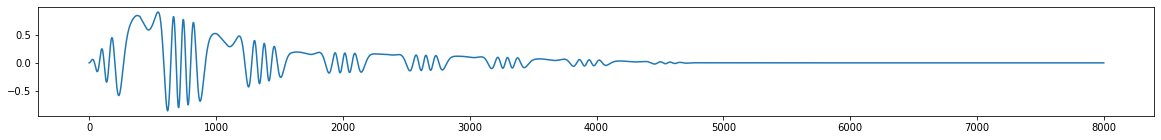

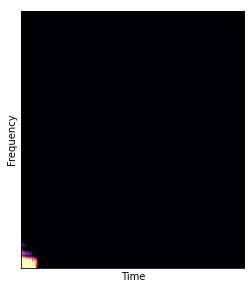

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [112]:
import ddsp
from ddsp import core
"""
Decoder:
In: piano_roll 
Out: 
->

Every processor gets an carrier_f, f0_mod, amp from the network
but they can be modulated before being applied as well

Processor B get carrier_f, amp from midi, so it only needs something to be modulated with: output of A



A:
    carrier: zeros
    modulator_f: network
    modulator_amp: network 
B:
    carrier: f0 from piano roll
    modulator_f: A->modulated_phase
    modulator_amp: network
C:
    carrier: B->out
    modulator_f: D->out
    modulator_amp: E->out

Imagine this as a SIREN hypernetwork: a SIREN layer modulates its input
with hidden activation, which are itself modulated versions of the input
SIREN would be:
initial layer: timesteps according to f0, generates sin waves with f=w*f0
next layer: sin(Wx + b) = sin(W sin(W'x') + W b' + b) => input modulates wave of freq w

modulates sin waves according to layer weights or hyperparam output ()
c: 0, mod_f_a, mod_amp_a -> m

(f0, amp)-------------|
                      |
(0, f0_a, amp_a)      |
|                     |
A --------------------|- B

(0, f0_c, amp_c)

C +
        |--- signal
C ----- D


"""
class Wave(ddsp.processors.Processor):
  """Final processor of a FM Synth: turns the modulated frequency and amplitude
  into an audio signal
  """
  def __init__(self, name, wave_func=sinus1hz, time_axis=0, sample_rate=250,  n_samples=1000):
    super().__init__(name)
    self.wave_func = wave_func
    self.time_axis = time_axis
    self.sample_rate = sample_rate
    self.n_samples = n_samples
  
  def get_controls(self, f0, amp):
    return {'f0': f0, 'amp': amp}

  def get_signal(self, f0, amp):
    phase = tf.cumsum(core.resample(f0, self.n_samples), axis=self.time_axis)
    amp = core.resample(amp, self.n_samples)
    return self.wave_func(phase, sample_rate=self.sample_rate) * amp

class ModulationProcessor(ddsp.processors.Processor):
    def __init__(self, name, wave_func=sinus1hz, time_axis=0, sample_rate=1000):
        super().__init__(name)
        self.wave_func = wave_func
        self.time_axis = time_axis
        self.sample_rate = sample_rate
    
    def get_signal(self, carrier_f, modulator_f, modulator_amp):
        modulated_phase = carrier_f + self.wave_func(
            tf.cumsum(modulator_f, axis=self.time_axis),
            sample_rate=self.sample_rate) * modulator_amp
        return modulated_phase
    
    def get_controls(self, carrier_f, modulator_f, modulator_amp):
        return {'carrier_f': carrier_f, 'modulator_f': modulator_f, 'modulator_amp': modulator_amp}


class NoteSynth():
    def __init__(self, dag, envelope, features, latent_frames=1000, sample_rate=16000, total_frames=64000):
        self.features = features
        self.dag = dag
        self.envelope = envelope
        self.sample_rate = sample_rate
        self.total_frames = 16000
        self.latent_frames = 1000
        self.time = tf.cast(tf.range(total_frames), tf.float32)
    
    def get_amp_env(self, note):
        amps = 0*self.time + note.vel
        attack = int(self.sample_rate * self.envelope.attack)
        decay = int(self.sample_rate * self.envelope.decay)
        relieve_start = int(self.sample_rate * note.dur)
        decay = tf.minimum(decay, relieve_start)
        relieve_end =  int(self.sample_rate * (note.dur + self.envelope.relieve))
        p1 = amps[:attack] * linspace(0., 1., attack)
        p2 = amps[attack:decay] * linspace(1., self.envelope.sustain, decay - attack)
        p3 = amps[decay:relieve_start]*0 + self.envelope.sustain
        p4 = linspace(self.envelope.sustain, 0., relieve_end - relieve_start)
        p5 = 0 * amps[relieve_end:]
        amps = tf.concat([p1, p2, p3, p4, p5], axis=0)
        return amps

    def __call__(self, note):
        amps = self.get_amp_env(note)
        f0_midi = tf.cast(tf.range(self.latent_frames), tf.float32)*0 + note.hz
        features = dict(**self.features, f0_from_midi=f0_midi, loudness_env=amps)
        return self.dag(features)


latent_time = tf.cast(tf.range(1000), tf.float32)
features = {
    'a_f0': latent_time*0 + 80,
    'a_f_mod': latent_time*0 + 90.,
    'a_amp': latent_time*0 + 1.,
    'b_amp': latent_time*0 + 2.,
    'c_f0': latent_time*0 + 120., 
    'c_f_mod': latent_time*0 + 2.,
    'c_amp': 1.,
}

A = ModulationProcessor('A', square1hz)
B = ModulationProcessor('B')
C = ModulationProcessor('C')
D = ModulationProcessor('D')
final = Wave('ModulatedFrequencyToAudio', sample_rate=16000, n_samples=64000)


dag = ddsp.processors.ProcessorGroup(dag=[
    (A, ['a_f0', 'a_f_mod', 'a_amp']),
    (B, ['f0_from_midi', 'A/signal', 'b_amp']),
    (C, ['c_f0', 'c_f_mod', 'c_amp']),
    (D, ['f0_from_midi', 'B/signal', 'C/signal']),
    (final, ['D/signal', 'loudness_env'])
])


synth_a = NoteSynth(features=features, dag=dag, envelope=ADSREnvelope(0.025, sustain=0.2, relieve=0.2))
note = Note(0, 0.1, 1, 100)
audio = synth_a(note)
play(audio)

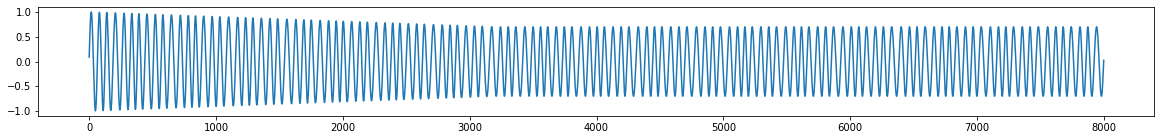

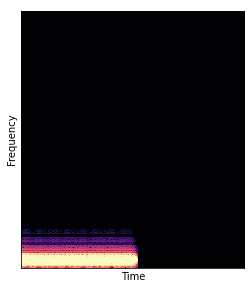

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [109]:


latent_time = tf.cast(tf.range(1000), tf.float32)
features = {
    'a_f_mod': latent_time*0 + 280,
    'a_amp': latent_time*0 + 0.1
}

A = ModulationProcessor('A', saw1hz)
final = Wave('ModulatedFrequencyToAudio', sample_rate=16000, n_samples=64000)


dag = ddsp.processors.ProcessorGroup(dag=[
    (A, ['f0_from_midi', 'a_f_mod', 'a_amp']),
    (final, ['A/signal', 'loudness_env'])
])




synth_b = NoteSynth(features=features, dag=dag, envelope=ADSREnvelope(0.0))
note = Note(0, 2, 1, 200)
audio = synth_b(note)
play(audio)

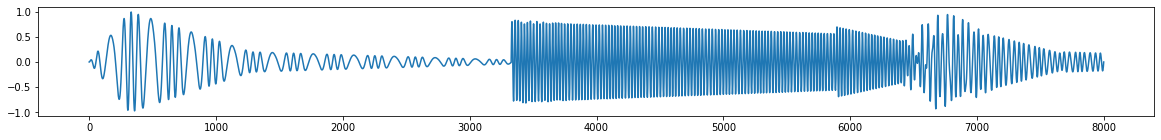

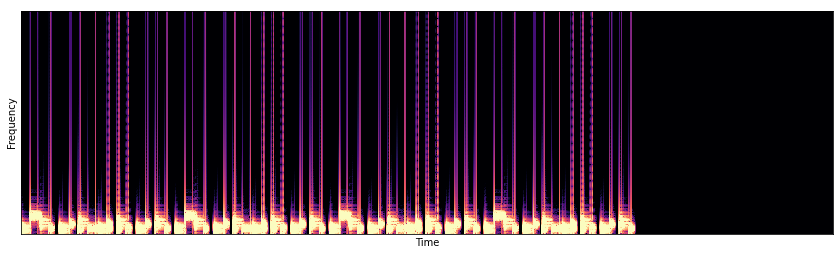

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [113]:
c_a = {
    'note_synth': synth_a,
    'notes': [
        Note(0, 0.1, 1, 200),
        Note(0.5, 0.1, 0.8, 400),
        Note(1, 0.1, 0.8, 200),
        Note(1.5, 0.1, 0.8, 400),
        Note(2, 0.1, 0.8, 200),
        Note(2.5, 0.1, 0.8, 400),
        Note(3, 0.1, 0.8, 200),
        Note(3.5, 0.1, 0.8, 400),
    ]
}


c_b = {
    'note_synth': synth_b,
    'notes': [
        Note(0.26, 0.2, 0.8, 600),
        Note(0.74, 0.05, 0.5, 150),
        Note(1.27, 0.05, 0.8, 300),
        Note(1.501, 0.05, 0.5, 150),
        Note(1.7503, 0.2, 0.5, 150),
        Note(2.246, 0.05, 0.8, 300),
        Note(2.5, 0.05, 0.8, 300),
        Note(2.746, 0.05, 0.5, 150),
        Note(2.25, 0.05, 0.5, 150),
        Note(2.506, 0.05, 0.5, 150),
        Note(2.7503, 0.05, 0.5, 150),
        Note(3.246, 0.05, 0.8, 300),
        Note(3.5, 0.05, 0.8, 300),
        Note(3.746, 0.05, 0.5, 150),
    ]
}

loop = Loop(4, channels=[c_a, c_b])
loop.change_tempo(3.2)

audio = loop.synthesize(4)
play(audio)

# Synthesizer in tf

This is a very simple approach where a bunch of operations are stacked upon each other. A single modulation can be created as a ddsp DAG that reads carrier and modulation frequency from the features, but it can also be done different: e.g. by computing the modulation frequency as a multiple of the carrier frequency.
We could also try to rebuild this https://cymatics.fm/blogs/production/fm-synthesis


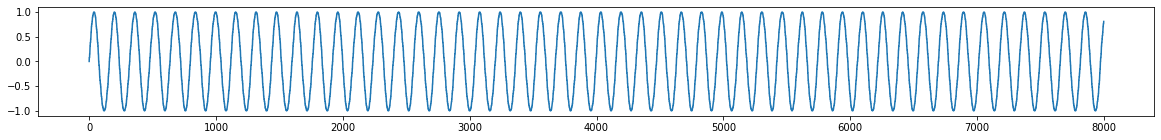

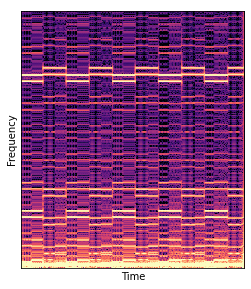

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [29]:
def stacked_modulations(*modulators):
    """
    modulators: op, frequency, amplitude
    ((arg1 modulates arg2) modulates arg3) modulates ... modulates carrier
    i.e. carrier should be the last in the list
    """
    modulators = list(modulators)
    f_mod = None
    while len(modulators) > 0:
        op, f, a = modulators.pop(0)
        if f_mod is None:
            f_mod = f * 0 # the first signal is not modulated
            previous_a = f * 0
            previous_op = lambda i, j, k: i
        f_mod = previous_op(f, f_mod, previous_a)
        previous_op, previous_a = op, a
    return op(0 * f, f_mod, a)

# audio = stacked_modulations(
#     (Modulator(lambda t: sinus1hz(-t)), time*0 + 1/5, 40),
#     (Modulator(sinus1hz), time*0 + 10, 0.25),
#     (RelativeModulator(sinus1hz), time*0 + 0.5, 40),
#     (Modulator(sinus1hz), time*0 + 200, 1)
# )


op = RelativeModulator(wave_func=square1hz,time_axis=0)

audio = stacked_modulations(
    (op, time*0 + 1.1, 100),
    (op, time*0 + 1.1, 100),
    (Modulator(sinus1hz), time*0 + 100, 1)
)


play(audio)

In [ ]:
class NoteSynthStacked():
    def __init__(self, modulators, envelope, sample_rate=16000, total_frames=64000):
        self.modulators = modulators
        self.envelope = envelope
        self.sample_rate = sample_rate
        self.total_frames = 16000
        self.time = tf.cast(tf.range(total_frames), tf.float32)
    
    def __call__(self, note):
        amps = 0*self.time + note.vel
        attack = int(self.sample_rate * self.envelope.attack)
        decay = int(self.sample_rate * self.envelope.decay)
        relieve_start = int(self.sample_rate * note.dur)
        decay = tf.minimum(decay, relieve_start)
        relieve_end =  int(self.sample_rate * (note.dur + self.envelope.relieve))
        p1 = amps[:attack] * linspace(0., 1., attack)
        p2 = amps[attack:decay] * linspace(1., self.envelope.sustain, decay - attack)
        p3 = amps[decay:relieve_start]*0 + self.envelope.sustain
        p4 = linspace(self.envelope.sustain, 0., relieve_end - relieve_start)
        p5 = 0 * amps[relieve_end:]
        amps = tf.concat([p1, p2, p3, p4, p5], axis=0)

        sound = stacked_modulations(*self.modulators + [(Modulator(sinus1hz), self.time*0+note.hz, amps)])
        return sound

modulators = [
    (Modulator(lambda t: sinus1hz(-t)), time*0 + 1/5, 40),
    (Modulator(square1hz), time*0 + 70, 40)
]
synth_a = NoteSynth(modulators, ADSREnvelope(0.0))


modulators = [
    (Modulator(lambda t: sinus1hz(-t)), time*0 + 1/5, 40),
    (Modulator(sinus1hz), time*0 + 10, 0.25),
    (RelativeModulator(sinus1hz), time*0 + 0.5, 40),
]
synth_b = NoteSynth(modulators, ADSREnvelope(0.05))


c_a = {
    'note_synth': synth_a,
    'notes': [
        Note(0, 0.1, 1, 200),
        Note(0.5, 0.1, 0.8, 400),
        Note(1, 0.1, 0.8, 200),
        Note(1.5, 0.1, 0.8, 400),
        Note(2, 0.1, 0.8, 200),
        Note(2.5, 0.1, 0.8, 400),
        Note(3, 0.1, 0.8, 200),
        Note(3.5, 0.1, 0.8, 400),
    ]
}


c_b = {
    'note_synth': synth_b,
    'notes': [
        Note(0.26, 0.2, 0.8, 600),
        Note(0.74, 0.05, 0.5, 150),
        Note(1.27, 0.05, 0.8, 300),
        Note(1.501, 0.05, 0.5, 150),
        Note(1.7503, 0.2, 0.5, 150),
        Note(2.246, 0.05, 0.8, 300),
        Note(2.5, 0.05, 0.8, 300),
        Note(2.746, 0.05, 0.5, 150),
        Note(2.25, 0.05, 0.5, 150),
        Note(2.506, 0.05, 0.5, 150),
        Note(2.7503, 0.05, 0.5, 150),
        Note(3.246, 0.05, 0.8, 300),
        Note(3.5, 0.05, 0.8, 300),
        Note(3.746, 0.05, 0.5, 150),
    ]
}

loop = Loop(4, channels=[c_a, c_b])
loop.change_tempo(3.2)

audio = loop.synthesize(4)
play(audio)

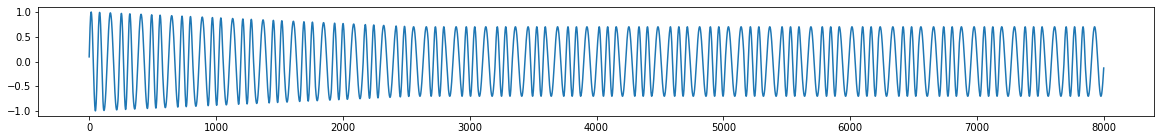

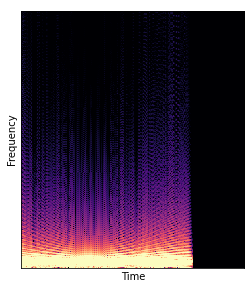

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [220]:
play(synth_a(Note(2, 3, 1, 200)))

# Neural network with FM synth


Variants:
- mod_f0, mod_amp are predicted six times and applied in stacked modulations
- we set predefined multiples of f0 and only predict the weights for a weighted sum (if multiples are ints, it is harmonic synthesis)


In [48]:
a = [1, 2, 3]
a.pop(0)

1